The fitting may need to be done several times to find the best range of the parameters. After these adjustments, all parameters have few outliers. And it is possible to use np.interp to interpolate some of the parameter-vs-E curves.

# Tools

In [2]:
%matplotlib notebook
from matplotlib import pyplot as plt

In [3]:
import numpy as np
import histogram.hdf as hh, histogram as H
import lmfit

In [28]:
import sys
sys.path.append('/home/fi0/dev/sandbox/SR-INS/Resolution/dgsres/dgsres/')
import powder
# from dgsres import icg

# Fit

In [29]:
from powder import fit

In [30]:
params = lmfit.Parameters()
# at first the max was 1.0. after trying it, it seems better to set max to 0.6 because points outside the range look like outliers
params.add('a', min=0., max=.3)
# at first the max was 0.3. 
params.add('b', min=0., max=.11)
params.add('R', value=0.3, vary=False)
params.add('sigma', min=0., max=20.)
params.add('t0', min=0., max=100.)

Ei = 130.
geom = icg.Geom(l1=11.6, l2=2.0, l3=3.)

fitIE = fit.Fit_IE(
    simout="/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/Ei_130/out",
    Ei=Ei,
    params = params,
    geom = geom,
)
Q = 7.

In [31]:
%%time
results = {}
for E0 in np.arange(0., Ei-1, 10.):
    print E0
    results[E0] = fitIE.fit(Q=Q, E=E0)
    continue

0.0


IOError: unable to load histogram. filename=/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/Ei_130/out, pathinfile=ie-Q_7.0-E_0.0.h5, kwds={}

<IPython.core.display.Javascript object>


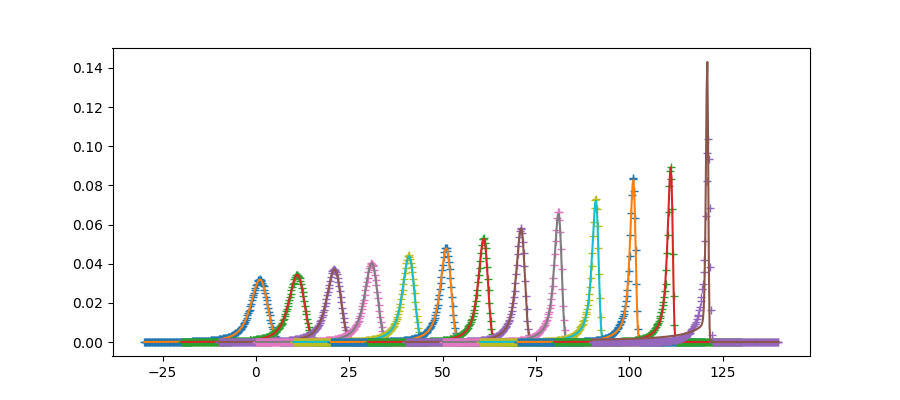

In [12]:
plt.figure(figsize=(9, 4))
for E0 in np.arange(0., Ei-1, 10.):
    x,y0,y0err = fitIE.getData(Q, E0)
    y = icg.resolution(x, Ei=Ei, E0=E0, geom=geom, **results[E0].params.valuesdict())
    y/=y.sum()
    # plt.errorbar(x, y0, y0err)
    plt.plot(x,y0, '+')
    plt.plot(x, y)
plt.show()

In [8]:
E0s = np.arange(0., Ei-1, 10.)
def get_p_list(name):
    return [results[E0].params[name].value for E0 in E0s]

The plot generated by the following cell can clearly show how many outliers exist for parameters. Try to minimize the number of outliers by changing the parameters (up in the `fitting parameters` section) and execute all the cells in between that cell and the next cell

<IPython.core.display.Javascript object>


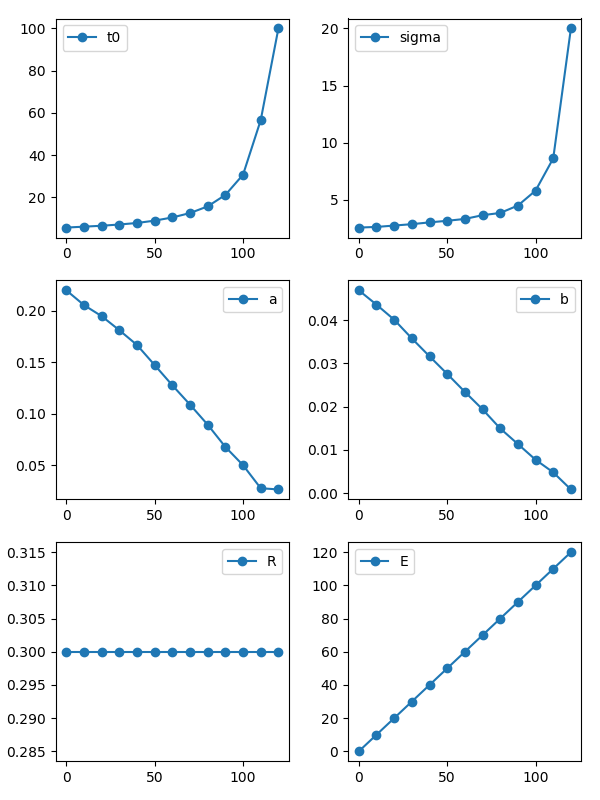

In [13]:
variables = 't0 sigma a b R'.split()
plt.figure(figsize=(6,8))
for i,v in enumerate(variables):
    plt.subplot(3, 2, i+1)
    plt.plot(E0s, get_p_list(v), '-o', label=v)
    plt.legend()
    continue

plt.subplot(3, 2, 6)
plt.plot(E0s, E0s, '-o', label='E')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
E0 = 0.
print results[E0].params['a'].value
print results[E0].params['b'].value

0.2200821284
0.0468900302165


# Interpolate

## a

<IPython.core.display.Javascript object>


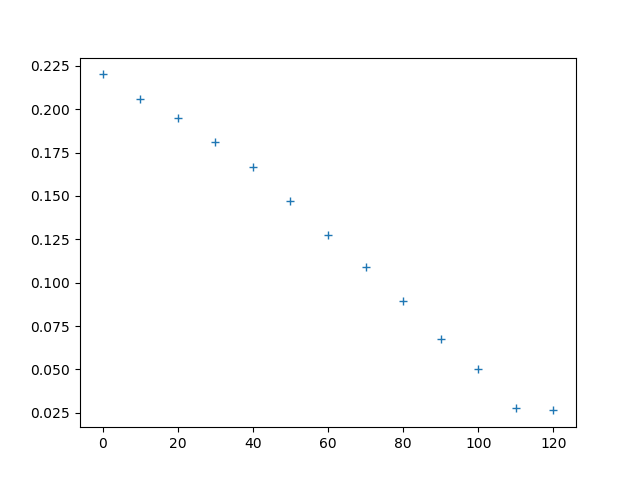

In [15]:
plt.figure()
x = E0s
y = np.array(get_p_list('a'))
plt.plot(x, y, '+')

There is one outlier. Here for simplicity we remove two points

In [16]:
good = x < 115
xgood = x[good]; ygood = y[good]

<IPython.core.display.Javascript object>


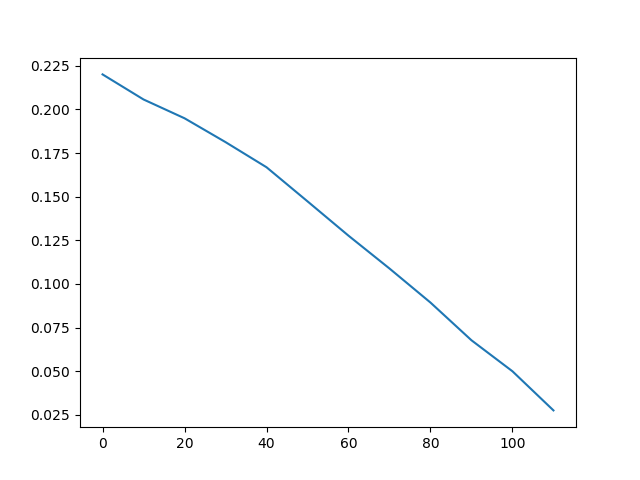

In [17]:
plt.figure()
plt.plot(xgood, ygood)

In [18]:
a2, a1, a0 = np.polyfit(xgood, ygood, 2)

<IPython.core.display.Javascript object>


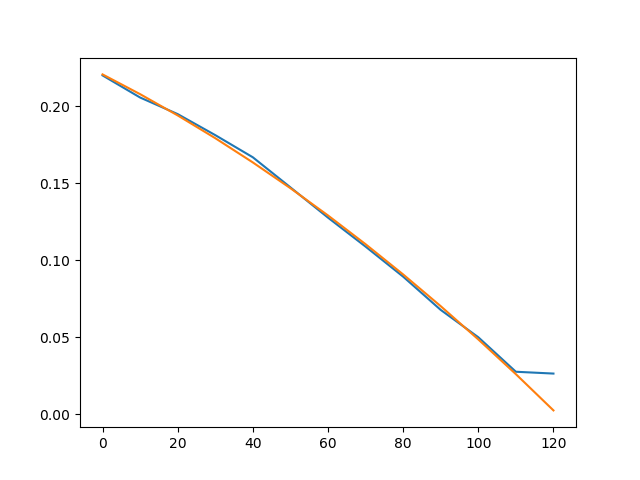

In [19]:
plt.figure()
plt.plot(x,y)
plt.plot(E0s, a0+a1*E0s+a2*E0s**2)

In [20]:
a0_a = a0; a1_a = a1; a2_a = a2

## b

<IPython.core.display.Javascript object>


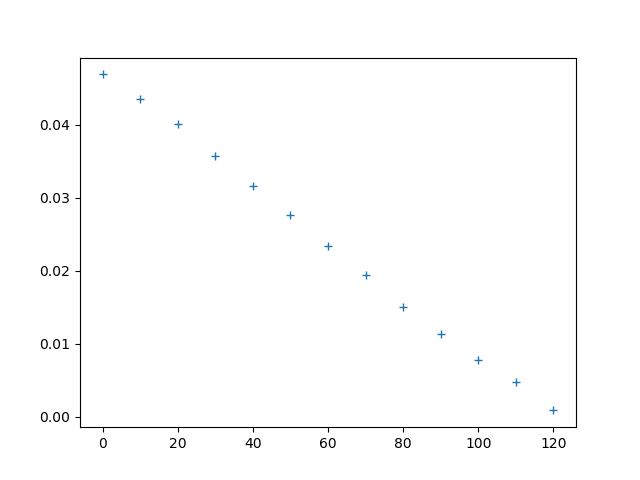

In [21]:
plt.figure()
x = E0s
y = np.array(get_p_list('b'))
plt.plot(x, y, '+')

In [22]:
a2, a1, a0 = np.polyfit(x, y, 2)

<IPython.core.display.Javascript object>


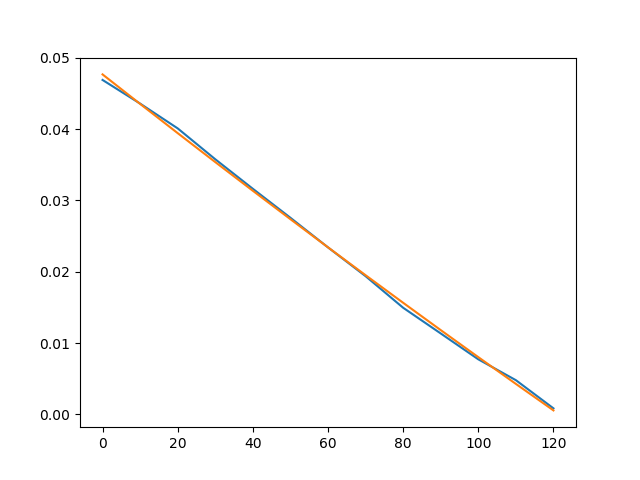

In [23]:
plt.figure()
plt.plot(x,y)
plt.plot(E0s, a0+a1*E0s+a2*E0s**2)

In [24]:
a0_b = a0; a1_b = a1; a2_b = a2

## t0
a and b are easy to fit. But t0 and sigma are harder to fit. We just do a simple interpolation

<IPython.core.display.Javascript object>


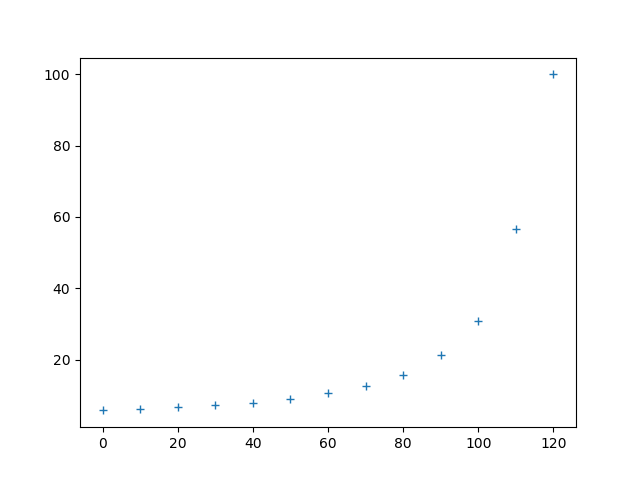

In [25]:
plt.figure()
plt.plot(E0s, get_p_list('t0'), '+')

There is no outlier

In [26]:
x_t0 = E0s.copy(); y_t0 = np.array(get_p_list('t0'))

## sigma

<IPython.core.display.Javascript object>


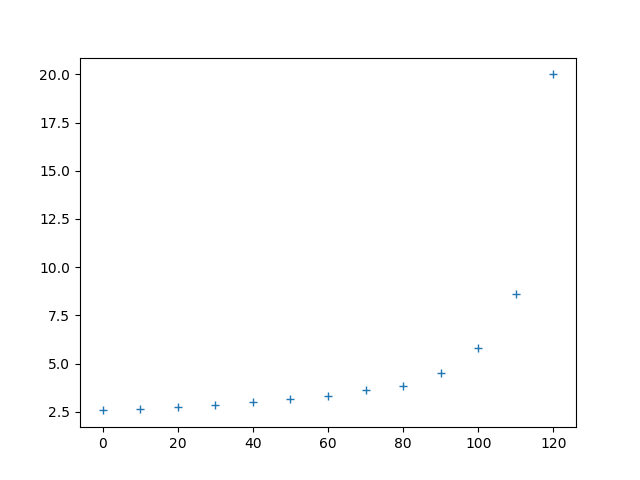

In [27]:
plt.figure()
plt.plot(E0s, get_p_list('sigma'), '+')

There is no outlier

In [28]:
# mask = E0s < 118.
x_sigma = E0s.copy(); y_sigma = np.array(get_p_list('sigma'))

# Save parameters

In [29]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [30]:
pwd

u'/home/lj7/dv/srins/graphite-DOS/notebooks'

In [31]:
%%writetemplate res_params_interped_funcs_Ei_130.py
import numpy as np
def parabolic(a0, a1, a2):
    return lambda E: a0 + a1*E + a2*E*E

a0_a = {a0_a}
a1_a = {a1_a}
a2_a = {a2_a}
a0_b = {a0_b}
a1_b = {a1_b}
a2_b = {a2_b}
from numpy import array
x_t0 = {x_t0!r}
y_t0 = {y_t0!r}
x_sigma = {x_sigma!r}
y_sigma = {y_sigma!r}

interped_funcs = dict(
    a = parabolic(a0_a, a1_a, a2_a),
    b = parabolic(a0_b, a1_b, a2_b),
    t0 = lambda E: np.interp(E, x_t0, y_t0),
    sigma = lambda E: np.interp(E, x_sigma, y_sigma),
    R = lambda E: 0*E+ 0.3, 
)

In [32]:
cat res_params_interped_funcs_Ei_130.py

import numpy as np
def parabolic(a0, a1, a2):
    return lambda E: a0 + a1*E + a2*E*E

a0_a = 0.220735832594
a1_a = -0.0012356210013
a2_a = -4.86453189362e-06
a0_b = 0.0476677481103
a1_b = -0.000415707214915
a2_b = 1.92210604173e-07
from numpy import array
x_t0 = array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.,  110.,  120.])
y_t0 = array([   5.74030747,    6.17078063,    6.60218515,    7.19238872,
          7.91124324,    9.02569315,   10.53174808,   12.61032027,
         15.78117089,   21.19391277,   30.7701625 ,   56.60375125,  100.        ])
x_sigma = array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.,  110.,  120.])
y_sigma = array([  2.56952213,   2.62595814,   2.74551247,   2.86743246,
         3.02381235,   3.16348315,   3.32458451,   3.65308239,
         3.84840911,   4.49697484,   5.80173869,   8.62287841,  20.        ])

interped_funcs = dict(
    a = parabolic(a0_a, a1_a, a2_a),
    b = parabol

In [33]:
import res_params_interped_funcs_Ei_130 as rpif_Ei_130
reload(rpif_Ei_130)

<module 'res_params_interped_funcs_Ei_130' from 'res_params_interped_funcs_Ei_130.pyc'>

# Test the interpolation / fitting

<IPython.core.display.Javascript object>


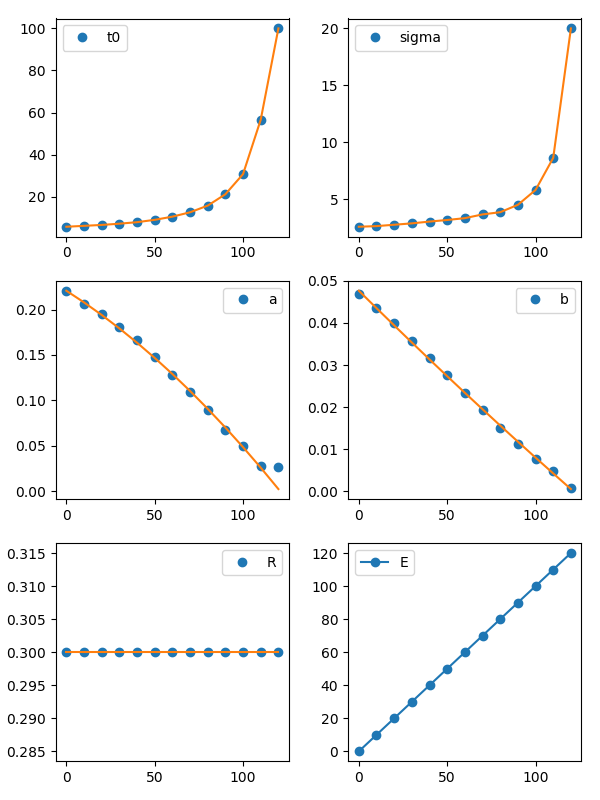

In [34]:
variables = 't0 sigma a b R'.split()
plt.figure(figsize=(6,8))

for i,v in enumerate(variables):
    plt.subplot(3, 2, i+1)
    x, y = E0s, get_p_list(v)
    plt.plot(x, y, 'o', label=v)
    # print v; break
    y2 = rpif_Ei_130.interped_funcs[v](x)
    plt.plot(x, y2)
    plt.legend()
    continue

plt.subplot(3, 2, 6)
plt.plot(E0s, E0s, '-o', label='E')
plt.legend()

plt.tight_layout()
plt.show()

Compare to sim data

<IPython.core.display.Javascript object>


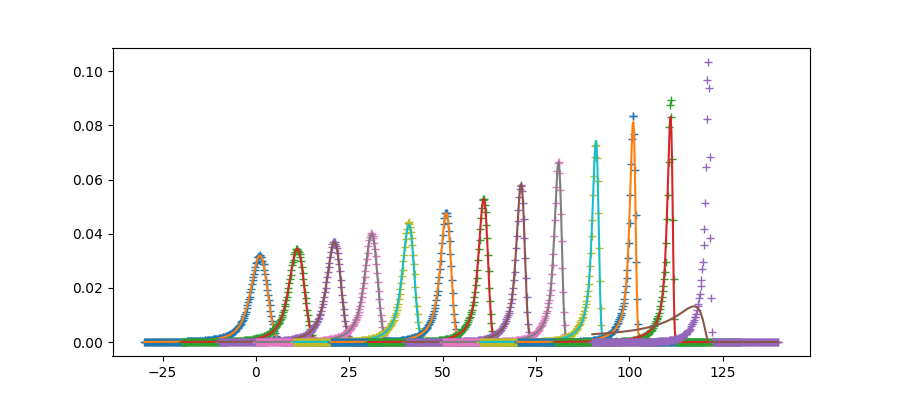

In [37]:
plt.figure(figsize=(9, 4))
for E0 in np.arange(0., Ei, 10.):
    x,y0,y0err = fitIE.getData(Q, E0)
    params = dict()
    for name in rpif_Ei_130.interped_funcs.keys():
        value = rpif_Ei_130.interped_funcs[name](E0)
        params[name] = value
    y = icg.resolution(x, Ei=Ei, E0=E0, geom=geom, **params)
    y/=y.sum()
    # plt.errorbar(x, y0, y0err)
    plt.plot(x,y0, '+')
    plt.plot(x, y)
plt.show()

Try some Energy transfer values that were not simulated by mcvine

In [38]:
interped_funcs = rpif_Ei_130.interped_funcs

<IPython.core.display.Javascript object>


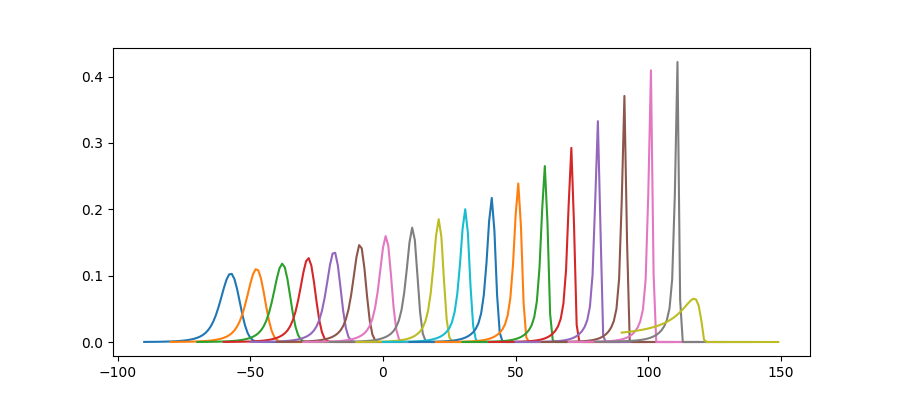

/home/lj7/miniconda2/envs/dev-mcvine/lib/python2.7/site-packages/dgsres-0.0.1a1-py2.7.egg/dgsres/icg.py:31: RuntimeWarning: divide by zero encountered in divide
/home/lj7/miniconda2/envs/dev-mcvine/lib/python2.7/site-packages/dgsres-0.0.1a1-py2.7.egg/dgsres/icg.py:51: RuntimeWarning: invalid value encountered in subtract
/home/lj7/miniconda2/envs/dev-mcvine/lib/python2.7/site-packages/dgsres-0.0.1a1-py2.7.egg/dgsres/icg.py:55: RuntimeWarning: invalid value encountered in subtract


In [39]:
plt.figure(figsize=(9, 4))
for E0 in np.arange(-60., 128., 10.):
    params = dict()
    for name in interped_funcs.keys():
        value = interped_funcs[name](E0)
        params[name] = value
    x = np.arange(E0-30, E0+30, 1.)
    y = icg.resolution(x, Ei=Ei, E0=E0, geom=geom, **params)
    y/=y.sum()
    # plt.errorbar(x, y0, y0err)
    plt.plot(x, y)
plt.show()

It is not very good after 110meV